In [1]:
import pandas as pd
import numpy as np
import cx_Oracle
import os
import json
import datetime
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings(action="ignore")
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.by import By
import bs4
import requests
import time
import math
import random
from shapely.geometry import Point, Polygon
import time as timesys
from pyproj import Geod
from haversine import haversine
pd.set_option('display.max_columns', None)

In [2]:
cf_port_mis_df = pd.read_csv("voy_path/AKA_BHUM_portmis.csv")
cf_port_mis_df

,voyage_name,port_in_time,port_out_time,next_port,previous_port
0,9V7282_2022_5,2022-08-02 12:30:00,2022-08-03 08:05:00,SHEKOU PT,TIANJIN XINGANG PT
1,9V7282_2022_6,2022-09-13 11:00:00,2022-09-14 02:58:00,SHANGHAI,TIANJIN XINGANG PT
2,9V7282_2022_7,2022-11-05 16:30:00,2022-11-06 05:59:00,SHANGHAI,TIANJIN XINGANG PT
3,9V7282_2022_8,2022-12-27 06:55:00,2022-12-28 00:15:00,SHANGHAI,TIANJIN XINGANG PT


In [3]:
tos_plan_berth = pd.read_csv("tos_plan_berth.csv")


In [4]:
time_before = cf_port_mis_df.loc[1,"port_out_time"]
time_before = pd.to_datetime(time_before)
time_after = cf_port_mis_df.loc[3,"port_out_time"]
time_after = pd.to_datetime(time_after)


In [5]:
tos_plan_berth["timestamp"] =pd.to_datetime(tos_plan_berth["timestamp"] )

In [6]:
time_before

Timestamp('2022-09-14 02:58:00')

In [7]:
time_after

Timestamp('2022-12-28 00:15:00')

In [8]:
tos_plan_aka_bhum = tos_plan_berth[(tos_plan_berth["timestamp"] > time_before) & (tos_plan_berth["timestamp"] < time_after )]
tos_plan_aka_bhum.reset_index(inplace=True, drop=True)

In [9]:
tos_plan_aka_bhum

,TML_NUM,TML_CD,TML_CUD,VSL_CD,CALL_YEAR,CALL_SEQ,VOYAGE,PTNR_CODE,BERTH_NO,ALONG_SIDE,FROM_BITT,TO_BITT,ETA,ETB,ETW,ETC,ETD,ATA,ATB,ATW,ATC,ATD,YARD_OPEN,YARD_CLOSE,DIS_QTY,LOAD_QTY,UPDATE_TIME,timestamp
0,1936,PNIT,U,MRSX,2022,1,MRSX001,HLC,T1,P,2.0,14,2022-09-15 18:00:00,2022-09-15 19:00:00,NaN,NaN,2022-09-16 05:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-12 19:00:00,2022-09-15 09:00:00,115,266,2022-09-13 16:46:34,2022-09-14 03:15:24.789179
1,1950,PNIT,U,MPER,2022,6,MPER006,MSC,T3,P,41.0,63,2022-09-17 00:00:00,2022-09-17 01:00:00,NaN,NaN,2022-09-19 01:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-14 01:00:00,2022-09-16 15:00:00,1000,2400,2022-09-13 16:46:34,2022-09-14 03:15:24.789179
2,1953,PNIT,U,CFOS,2022,19,CFOS019,COH,OT,P,54.0,70,2022-09-19 03:00:00,2022-09-19 04:00:00,NaN,NaN,2022-09-20 20:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-16 04:00:00,2022-09-18 18:00:00,1700,900,2022-09-13 16:46:35,2022-09-14 03:15:24.789179
3,1954,PNIT,U,CFOS,2022,20,CFOS020,COH,OT,P,54.0,70,2022-09-19 11:00:00,2022-09-19 12:00:00,NaN,NaN,2022-09-21 03:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-16 12:00:00,2022-09-19 02:00:00,1700,900,2022-09-13 16:46:35,2022-09-14 03:15:24.789179
4,1958,PNIT,U,MLUC,2022,3,MLUC003,MSC,T1,P,1.0,23,2022-09-16 06:00:00,2022-09-16 07:00:00,NaN,NaN,2022-09-17 09:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-13 07:00:00,2022-09-15 21:00:00,201,2000,2022-09-13 16:50:31,2022-09-14 03:15:24.789179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1636187,2760,PNIT,U,MAEE,2023,1,MAEE001,MSC,T2,P,NaN,NaN,2023-01-11 19:00:00,2023-01-11 20:00:00,NaN,NaN,2023-01-12 20:00:00,NaN,NaN,NaN,NaN,NaN,2023-01-07 20:00:00,2023-01-11 10:00:00,800,800,2022-12-27 13:48:02,2022-12-28 00:14:26.944769
1636188,2761,PNIT,C,MAEE,2023,2,MAEE002,MSC,T2,P,NaN,NaN,2023-01-21 05:00:00,2023-01-21 06:00:00,NaN,NaN,2023-01-22 03:00:00,NaN,NaN,NaN,NaN,NaN,2022-12-21 06:00:00,2023-01-20 20:00:00,800,800,NaN,2022-12-28 00:14:26.944769
1636189,2762,PNIT,U,MVMO,2023,1,MVMO001,MSC,T2,P,NaN,NaN,2023-01-18 19:00:00,2023-01-18 20:00:00,NaN,NaN,2023-01-19 20:00:00,NaN,NaN,NaN,NaN,NaN,2023-01-14 20:00:00,2023-01-18 10:00:00,800,800,2022-12-27 13:48:02,2022-12-28 00:14:26.944769
1636190,2763,PNIT,C,MVMO,2023,2,MVMO002,MSC,T2,P,NaN,NaN,2023-01-28 05:00:00,2023-01-28 06:00:00,NaN,NaN,2023-01-29 03:00:00,NaN,NaN,NaN,NaN,NaN,2022-12-28 06:00:00,2023-01-27 20:00:00,800,800,NaN,2022-12-28 00:14:26.944769


In [10]:
AKA_BHUM_VSL_CD = 'AKBM'

In [11]:
tos_plan_aka_bhum = tos_plan_aka_bhum.query(f'VSL_CD == "{AKA_BHUM_VSL_CD}"')
tos_plan_aka_bhum

,TML_NUM,TML_CD,TML_CUD,VSL_CD,CALL_YEAR,CALL_SEQ,VOYAGE,PTNR_CODE,BERTH_NO,ALONG_SIDE,FROM_BITT,TO_BITT,ETA,ETB,ETW,ETC,ETD,ATA,ATB,ATW,ATC,ATD,YARD_OPEN,YARD_CLOSE,DIS_QTY,LOAD_QTY,UPDATE_TIME,timestamp
72044,1955,PNIT,U,AKBM,2022,2,AKBM002,RCL,T1,P,1.0,19,2022-09-13 10:00:00,2022-09-13 11:00:00,NaN,NaN,2022-09-14 03:00:00,NaN,2022-09-13 11:00:00,2022-09-13 12:13:00,2022-09-14 01:48:00,2022-09-14 03:00:00,2022-09-10 11:00:00,2022-09-13 01:00:00,857,204,2022-09-14 13:00:19,2022-10-19 17:00:33.397252
72172,1774,PNIT,U,AKBM,2022,1,AKBM001,RCL,T2,P,21.0,39,2022-08-02 12:00:00,2022-08-02 13:00:00,NaN,NaN,2022-08-03 08:00:00,NaN,2022-08-02 12:35:00,2022-08-02 14:00:00,2022-08-03 07:14:00,2022-08-03 08:00:00,2022-07-30 13:00:00,2022-08-02 12:00:00,1156,761,2022-08-03 08:53:44,2022-10-19 17:00:33.397252
73370,1955,PNIT,U,AKBM,2022,2,AKBM002,RCL,T1,P,1.0,19,2022-09-13 10:00:00,2022-09-13 11:00:00,NaN,NaN,2022-09-14 03:00:00,NaN,2022-09-13 11:00:00,2022-09-13 12:13:00,2022-09-14 01:48:00,2022-09-14 03:00:00,2022-09-10 11:00:00,2022-09-13 01:00:00,857,204,2022-09-14 13:00:19,2022-10-19 17:01:30.995609
73498,1774,PNIT,U,AKBM,2022,1,AKBM001,RCL,T2,P,21.0,39,2022-08-02 12:00:00,2022-08-02 13:00:00,NaN,NaN,2022-08-03 08:00:00,NaN,2022-08-02 12:35:00,2022-08-02 14:00:00,2022-08-03 07:14:00,2022-08-03 08:00:00,2022-07-30 13:00:00,2022-08-02 12:00:00,1156,761,2022-08-03 08:53:44,2022-10-19 17:01:30.995609
74696,1955,PNIT,U,AKBM,2022,2,AKBM002,RCL,T1,P,1.0,19,2022-09-13 10:00:00,2022-09-13 11:00:00,NaN,NaN,2022-09-14 03:00:00,NaN,2022-09-13 11:00:00,2022-09-13 12:13:00,2022-09-14 01:48:00,2022-09-14 03:00:00,2022-09-10 11:00:00,2022-09-13 01:00:00,857,204,2022-09-14 13:00:19,2022-10-19 17:08:28.754177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635406,2440,PNIT,U,AKBM,2022,4,AKBM004,RCL,T1,P,1.0,19.0,2022-12-27 06:00:00,2022-12-27 07:00:00,NaN,NaN,2022-12-28 00:00:00,NaN,2022-12-27 07:15:00,2022-12-27 08:22:00,NaN,NaN,2022-12-23 07:00:00,2022-12-26 08:00:00,970,345,2022-12-27 23:26:13,2022-12-27 23:39:22.128035
1635515,2440,PNIT,U,AKBM,2022,4,AKBM004,RCL,T1,P,1.0,19.0,2022-12-27 06:00:00,2022-12-27 07:00:00,NaN,NaN,2022-12-28 00:00:00,NaN,2022-12-27 07:15:00,2022-12-27 08:22:00,2022-12-27 23:41:00,2022-12-28 00:00:00,2022-12-23 07:00:00,2022-12-26 08:00:00,970,345,2022-12-27 23:42:10,2022-12-27 23:44:22.857306
1635624,2440,PNIT,U,AKBM,2022,4,AKBM004,RCL,T1,P,1.0,19.0,2022-12-27 06:00:00,2022-12-27 07:00:00,NaN,NaN,2022-12-28 00:00:00,NaN,2022-12-27 07:15:00,2022-12-27 08:22:00,2022-12-27 23:41:00,2022-12-28 00:00:00,2022-12-23 07:00:00,2022-12-26 08:00:00,970,342,2022-12-27 23:46:39,2022-12-27 23:49:23.631514
1635733,2440,PNIT,U,AKBM,2022,4,AKBM004,RCL,T1,P,1.0,19.0,2022-12-27 06:00:00,2022-12-27 07:00:00,NaN,NaN,2022-12-28 00:00:00,NaN,2022-12-27 07:15:00,2022-12-27 08:22:00,2022-12-27 23:41:00,2022-12-28 00:00:00,2022-12-23 07:00:00,2022-12-26 08:00:00,970,342,2022-12-27 23:46:39,2022-12-27 23:54:24.184925


In [12]:
set(tos_plan_aka_bhum.sort_values(by="VOYAGE")['VOYAGE'].values)

{'AKBM001', 'AKBM002', 'AKBM003', 'AKBM004'}

In [13]:
voyage_list = ['AKBM003','AKBM004']
for voyage in voyage_list:
    df = tos_plan_aka_bhum.query(f'VOYAGE == "{voyage}"')
    df.reset_index(inplace=True, drop=True)
    globals()[voyage + "_df"] = df
    display(df)

,TML_NUM,TML_CD,TML_CUD,VSL_CD,CALL_YEAR,CALL_SEQ,VOYAGE,PTNR_CODE,BERTH_NO,ALONG_SIDE,FROM_BITT,TO_BITT,ETA,ETB,ETW,ETC,ETD,ATA,ATB,ATW,ATC,ATD,YARD_OPEN,YARD_CLOSE,DIS_QTY,LOAD_QTY,UPDATE_TIME,timestamp
0,2216,PNIT,U,AKBM,2022,3,AKBM003,RCL,T2,P,23,41,2022-11-04 16:00:00,2022-11-04 17:00:00,NaN,NaN,2022-11-05 17:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-11 17:00:00,2022-11-04 07:00:00,600,500,2022-10-24 13:30:58,2022-10-24 13:35:28.074805
1,2216,PNIT,U,AKBM,2022,3,AKBM003,RCL,T2,P,23,41,2022-11-04 16:00:00,2022-11-04 17:00:00,NaN,NaN,2022-11-05 17:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-11 17:00:00,2022-11-04 07:00:00,600,500,2022-10-24 13:30:58,2022-10-24 13:40:31.602351
2,2216,PNIT,U,AKBM,2022,3,AKBM003,RCL,T1,P,01,19,2022-11-04 16:00:00,2022-11-04 17:00:00,NaN,NaN,2022-11-05 17:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-11 17:00:00,2022-11-04 07:00:00,600,500,2022-10-24 13:45:08,2022-10-24 13:45:33.702464
3,2216,PNIT,U,AKBM,2022,3,AKBM003,RCL,T1,P,01,19,2022-11-04 16:00:00,2022-11-04 17:00:00,NaN,NaN,2022-11-05 17:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-11 17:00:00,2022-11-04 07:00:00,600,500,2022-10-24 13:45:08,2022-10-24 13:50:36.672512
4,2216,PNIT,U,AKBM,2022,3,AKBM003,RCL,T1,P,01,19,2022-11-04 16:00:00,2022-11-04 17:00:00,NaN,NaN,2022-11-05 17:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-11 17:00:00,2022-11-04 07:00:00,600,500,2022-10-24 13:45:08,2022-10-24 13:55:40.261031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,2216,PNIT,U,AKBM,2022,3,AKBM003,RCL,T2,P,22.0,40.0,2022-11-05 18:00:00,2022-11-05 19:00:00,NaN,NaN,2022-11-06 08:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-02 19:00:00,2022-11-05 09:00:00,567,359,2022-11-05 08:29:53,2022-11-05 10:15:46.031596
3259,2216,PNIT,U,AKBM,2022,3,AKBM003,RCL,T2,P,22.0,40.0,2022-11-05 18:00:00,2022-11-05 19:00:00,NaN,NaN,2022-11-06 08:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-02 19:00:00,2022-11-05 09:00:00,567,359,2022-11-05 08:29:53,2022-11-05 10:20:48.996265
3260,2216,PNIT,U,AKBM,2022,3,AKBM003,RCL,T2,P,22.0,40.0,2022-11-05 18:00:00,2022-11-05 19:00:00,NaN,NaN,2022-11-06 08:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-02 19:00:00,2022-11-05 09:00:00,567,359,2022-11-05 08:29:53,2022-11-05 10:25:52.083306
3261,2216,PNIT,U,AKBM,2022,3,AKBM003,RCL,T2,P,22.0,40.0,2022-11-05 18:00:00,2022-11-05 19:00:00,NaN,NaN,2022-11-06 08:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-02 19:00:00,2022-11-05 09:00:00,567,359,2022-11-05 08:29:53,2022-11-05 10:30:54.717591


,TML_NUM,TML_CD,TML_CUD,VSL_CD,CALL_YEAR,CALL_SEQ,VOYAGE,PTNR_CODE,BERTH_NO,ALONG_SIDE,FROM_BITT,TO_BITT,ETA,ETB,ETW,ETC,ETD,ATA,ATB,ATW,ATC,ATD,YARD_OPEN,YARD_CLOSE,DIS_QTY,LOAD_QTY,UPDATE_TIME,timestamp
0,2440,PNIT,C,AKBM,2022,4,AKBM004,RCL,T2,P,NaN,NaN,2022-12-23 16:00:00,2022-12-23 17:00:00,NaN,NaN,2022-12-24 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-23 17:00:00,2022-12-23 07:00:00,600,500,NaN,2022-11-21 16:49:56.710003
1,2440,PNIT,C,AKBM,2022,4,AKBM004,RCL,T2,P,NaN,NaN,2022-12-23 16:00:00,2022-12-23 17:00:00,NaN,NaN,2022-12-24 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-23 17:00:00,2022-12-23 07:00:00,600,500,NaN,2022-11-21 16:54:59.602473
2,2440,PNIT,C,AKBM,2022,4,AKBM004,RCL,T2,P,NaN,NaN,2022-12-23 16:00:00,2022-12-23 17:00:00,NaN,NaN,2022-12-24 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-23 17:00:00,2022-12-23 07:00:00,600,500,NaN,2022-11-21 17:10:08.150558
3,2440,PNIT,C,AKBM,2022,4,AKBM004,RCL,T2,P,NaN,NaN,2022-12-23 16:00:00,2022-12-23 17:00:00,NaN,NaN,2022-12-24 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-23 17:00:00,2022-12-23 07:00:00,600,500,NaN,2022-11-21 17:15:11.057334
4,2440,PNIT,C,AKBM,2022,4,AKBM004,RCL,T2,P,NaN,NaN,2022-12-23 16:00:00,2022-12-23 17:00:00,NaN,NaN,2022-12-24 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-23 17:00:00,2022-12-23 07:00:00,600,500,NaN,2022-11-21 17:20:13.499251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9846,2440,PNIT,U,AKBM,2022,4,AKBM004,RCL,T1,P,1.0,19.0,2022-12-27 06:00:00,2022-12-27 07:00:00,NaN,NaN,2022-12-28 00:00:00,NaN,2022-12-27 07:15:00,2022-12-27 08:22:00,NaN,NaN,2022-12-23 07:00:00,2022-12-26 08:00:00,970,345,2022-12-27 23:26:13,2022-12-27 23:39:22.128035
9847,2440,PNIT,U,AKBM,2022,4,AKBM004,RCL,T1,P,1.0,19.0,2022-12-27 06:00:00,2022-12-27 07:00:00,NaN,NaN,2022-12-28 00:00:00,NaN,2022-12-27 07:15:00,2022-12-27 08:22:00,2022-12-27 23:41:00,2022-12-28 00:00:00,2022-12-23 07:00:00,2022-12-26 08:00:00,970,345,2022-12-27 23:42:10,2022-12-27 23:44:22.857306
9848,2440,PNIT,U,AKBM,2022,4,AKBM004,RCL,T1,P,1.0,19.0,2022-12-27 06:00:00,2022-12-27 07:00:00,NaN,NaN,2022-12-28 00:00:00,NaN,2022-12-27 07:15:00,2022-12-27 08:22:00,2022-12-27 23:41:00,2022-12-28 00:00:00,2022-12-23 07:00:00,2022-12-26 08:00:00,970,342,2022-12-27 23:46:39,2022-12-27 23:49:23.631514
9849,2440,PNIT,U,AKBM,2022,4,AKBM004,RCL,T1,P,1.0,19.0,2022-12-27 06:00:00,2022-12-27 07:00:00,NaN,NaN,2022-12-28 00:00:00,NaN,2022-12-27 07:15:00,2022-12-27 08:22:00,2022-12-27 23:41:00,2022-12-28 00:00:00,2022-12-23 07:00:00,2022-12-26 08:00:00,970,342,2022-12-27 23:46:39,2022-12-27 23:54:24.184925


# 항차 데이터 확인

## 항차 확인

In [14]:
aka_bhum_7 = pd.read_csv("실험/230204_exp_result_df_4_2_1_3_seg_100_voy_7")
aka_bhum_7

,vessel_name,mmsi,imo,CAPACITY,destination,eta,longitude,latitude,speed,heading,timestamp,time_position_data_received,time_voyage_data_received,navigation_info,remained_distance,estimated_fuel_consumption,ETA,ATA,error
0,AKA BHUM,563135800,9307011.0,5888,KRBNP,11040600,117.8023,38.9730,9.6,133.0,2022-11-02 13:46:10.578457,2022-11-02 04:45:11.000000,2022-11-02 04:44:30.000000,under way using engine,1074.232436,1807.481701,2022-11-05 12:17:05.081740,2022-11-05 10:36:09.691120,0 days 01:40:55.390620
1,AKA BHUM,563135800,9307011.0,5888,KRBNP,11040600,117.8077,38.9692,9.4,129.0,2022-11-02 13:51:12.917427,2022-11-02 04:47:16.000000,2022-11-02 04:44:30.000000,under way using engine,1073.644946,1810.848078,2022-11-05 12:22:07.420710,2022-11-05 10:36:09.691120,0 days 01:45:57.729590
2,AKA BHUM,563135800,9307011.0,5888,KRBNP,11050900,118.0403,38.9269,7.1,118.0,2022-11-02 14:47:46.129923,2022-11-02 05:46:19.000000,2022-11-02 05:31:15.000000,under way using engine,1053.190809,1965.440518,2022-11-05 12:30:31.944204,2022-11-05 10:36:09.691120,0 days 01:54:22.253084
3,AKA BHUM,563135800,9307011.0,5888,KRBNP,11050900,118.0436,38.9257,8.0,115.0,2022-11-02 14:53:09.039079,2022-11-02 05:47:36.000000,2022-11-02 05:31:15.000000,under way using engine,1052.876352,1855.552092,2022-11-05 12:35:54.853360,2022-11-05 10:36:09.691120,0 days 01:59:45.162240
4,AKA BHUM,563135800,9307011.0,5888,KRBNP,11050900,118.1269,38.8976,16.8,129.0,2022-11-02 15:12:49.646277,2022-11-02 06:06:35.000000,2022-11-02 05:56:14.000000,under way using engine,1045.025952,2326.738581,2022-11-05 12:10:03.689436,2022-11-05 10:36:09.691120,0 days 01:33:53.998316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,AKA BHUM,563135800,9307011.0,5888,KRBNP,11050900,128.9396,34.7394,7.4,49.0,2022-11-05 10:05:50.892397,2022-11-05 01:04:21.000000,2022-11-05 01:02:10.000000,under way using engine,27.846130,50.840113,NaN,2022-11-05 10:36:09.691120,NaN
345,AKA BHUM,563135800,9307011.0,5888,KRBNP,11050900,128.9572,34.7526,7.2,32.0,2022-11-05 10:15:56.270667,2022-11-05 01:13:52.000000,2022-11-05 01:08:12.000000,under way using engine,27.206372,50.386077,NaN,2022-11-05 10:36:09.691120,NaN
346,AKA BHUM,563135800,9307011.0,5888,KRBNP,11050900,128.9654,34.7630,7.2,30.0,2022-11-05 10:20:59.178779,2022-11-05 01:20:06.000000,2022-11-05 01:20:10.000000,under way using engine,26.552967,49.175973,NaN,2022-11-05 10:36:09.691120,NaN
347,AKA BHUM,563135800,9307011.0,5888,KRBNP,11050900,128.9789,34.7798,7.3,29.0,2022-11-05 10:31:04.891425,2022-11-05 01:30:01.000000,2022-11-05 01:20:10.000000,under way using engine,25.631893,47.124963,NaN,2022-11-05 10:36:09.691120,NaN


In [15]:
aka_bhum_8 = pd.read_csv("실험/230204_exp_result_df_4_2_1_3_seg_100_voy_8")
aka_bhum_8

,vessel_name,mmsi,imo,CAPACITY,destination,eta,longitude,latitude,speed,heading,timestamp,time_position_data_received,time_voyage_data_received,navigation_info,remained_distance,estimated_fuel_consumption,ETA,ATA,error
0,AKA BHUM,563135800,9307011.0,5888,KRBNP,12261000,117.7867,38.9850,5.8,141.0,2022-12-23 22:21:31.730568,2022-12-23 13:20:17.000000,2022-12-23 01:13:57.000000,under way using engine,1075.970590,95.483137,2022-12-26 20:52:26.233851,2022-12-27 05:21:48.345475,0 days 08:29:22.111624
1,AKA BHUM,563135800,9307011.0,5888,KRBNP,12261000,117.8055,38.9715,9.5,122.0,2022-12-23 22:31:33.162788,2022-12-23 13:28:35.000000,2022-12-23 01:13:57.000000,under way using engine,1073.914337,75.371834,2022-12-26 21:02:27.666071,2022-12-27 05:21:48.345475,0 days 08:19:20.679404
2,AKA BHUM,563135800,9307011.0,5888,KRBNP,12261000,117.8621,38.9591,12.9,101.0,2022-12-23 22:46:36.107538,2022-12-23 13:43:53.000000,2022-12-23 01:43:59.000000,under way using engine,1068.852534,79.771653,2022-12-26 21:17:30.610821,2022-12-27 05:21:48.345475,0 days 08:04:17.734654
3,AKA BHUM,563135800,9307011.0,5888,KRBNP,12261000,117.9295,38.9488,12.8,101.0,2022-12-23 23:01:37.535444,2022-12-23 13:59:14.000000,2022-12-23 01:43:59.000000,under way using engine,1063.004161,79.010459,2022-12-26 21:32:32.038727,2022-12-27 05:21:48.345475,0 days 07:49:16.306748
4,AKA BHUM,563135800,9307011.0,5888,KRBNP,12261000,117.9460,38.9464,12.8,100.0,2022-12-23 23:06:37.713532,2022-12-23 14:02:58.000000,2022-12-23 01:43:59.000000,under way using engine,1061.577484,78.904418,2022-12-26 21:37:32.216815,2022-12-27 05:21:48.345475,0 days 07:44:16.128660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,AKA BHUM,563135800,9307011.0,5888,KRBNP,12260845,128.8497,34.8566,8.8,0.0,2022-12-27 04:51:43.617674,2022-12-26 19:50:57.000000,2022-12-26 07:49:57.000000,under way using engine,12.864228,0.915647,NaN,2022-12-27 05:21:48.345475,NaN
416,AKA BHUM,563135800,9307011.0,5888,KRBNP,12260845,128.8486,34.8716,9.0,350.0,2022-12-27 05:01:47.908403,2022-12-26 19:56:59.000000,2022-12-26 07:55:59.000000,under way using engine,11.216535,0.794226,NaN,2022-12-27 05:21:48.345475,NaN
417,AKA BHUM,563135800,9307011.0,5888,KRBNP,12260845,128.8454,34.8861,9.1,351.0,2022-12-27 05:06:45.055558,2022-12-26 20:02:46.000000,2022-12-26 07:55:59.000000,under way using engine,9.581446,0.676932,NaN,2022-12-27 05:21:48.345475,NaN
418,AKA BHUM,563135800,9307011.0,5888,KRBNP,12260845,128.8433,34.8962,9.2,350.0,2022-12-27 05:11:46.716352,2022-12-26 20:06:46.000000,2022-12-26 07:55:59.000000,under way using engine,8.446341,0.595544,NaN,2022-12-27 05:21:48.345475,NaN


In [16]:
aka_bhum_7["eta"].value_counts()

11050900    347
11040600      2
Name: eta, dtype: int64

In [17]:
aka_bhum_8["eta"].value_counts()

12261000    208
12271201    152
12260900     44
12260845     16
Name: eta, dtype: int64

In [18]:
aka_bhum_7["timestamp"] =pd.to_datetime(aka_bhum_7["timestamp"])
aka_bhum_7["error"] =pd.to_timedelta(aka_bhum_7["error"])
aka_bhum_7["ETA"] =pd.to_datetime(aka_bhum_7["ETA"])
aka_bhum_7["ATA"] =pd.to_datetime(aka_bhum_7["ATA"])
aka_bhum_7["time_position_data_received"] =pd.to_datetime(aka_bhum_7["time_position_data_received"])
aka_bhum_7["time_voyage_data_received"] =pd.to_datetime(aka_bhum_7["time_voyage_data_received"])
aka_bhum_7 = aka_bhum_7.loc[aka_bhum_7[["ETA", "error"]].dropna().index]
aka_bhum_7.reset_index(inplace=True)
aka_bhum_7["eta"] = aka_bhum_7["eta"].astype(str)
aka_bhum_7["ais_eta"] = aka_bhum_7["eta"].apply(lambda x: '2022-'+x[:2]+"-"+x[2:4]+" "+x[4:6] + ":" + x[6:8] + ":00")
aka_bhum_7["ais_eta"] =pd.to_datetime(aka_bhum_7["ais_eta"])


In [19]:
aka_bhum_8["timestamp"] =pd.to_datetime(aka_bhum_8["timestamp"])
aka_bhum_8["error"] =pd.to_timedelta(aka_bhum_8["error"])
aka_bhum_8["ETA"] =pd.to_datetime(aka_bhum_8["ETA"])
aka_bhum_8["ATA"] =pd.to_datetime(aka_bhum_8["ATA"])
aka_bhum_8["time_position_data_received"] =pd.to_datetime(aka_bhum_8["time_position_data_received"])
aka_bhum_8["time_voyage_data_received"] =pd.to_datetime(aka_bhum_8["time_voyage_data_received"])
aka_bhum_8 = aka_bhum_8.loc[aka_bhum_8[["ETA", "error"]].dropna().index]
aka_bhum_8.reset_index(inplace=True)
aka_bhum_8["eta"] = aka_bhum_8["eta"].astype(str)
aka_bhum_8["ais_eta"] = aka_bhum_8["eta"].apply(lambda x: '2022-'+x[:2]+"-"+x[2:4]+" "+x[4:6] + ":" + x[6:8] + ":00")
aka_bhum_8["ais_eta"] =pd.to_datetime(aka_bhum_8["ais_eta"])


# 입항 후 대기 여부

감속하지 않는 경우, 감속하는 경우 판단. 속도를 얼마동안 감속하는지 확인

In [20]:
from matplotlib.ticker import MultipleLocator, IndexLocator, FuncFormatter
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns

## 7

In [21]:
df = aka_bhum_7
voy_num = 7

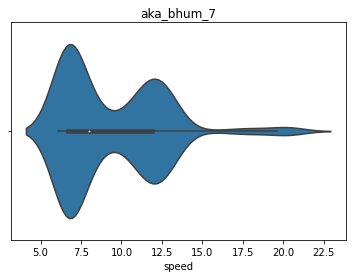

In [22]:
# use the seaborn violinplot function to visualize the distribution of the speed values
sns.violinplot(data=df, x='speed')
plt.title(f"aka_bhum_{voy_num}")

plt.show()

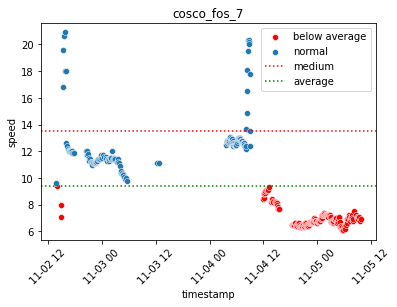

In [23]:
cosco_fos_26 = df
sns.scatterplot(
    data=cosco_fos_26[cosco_fos_26["speed"] < cosco_fos_26["speed"].mean()],
    x='timestamp',
    y='speed',
    color="red",
    label="below average")
sns.scatterplot(
    data=cosco_fos_26[cosco_fos_26["speed"] >= cosco_fos_26["speed"].mean()],
    x='timestamp',
    y='speed',
    label="normal")
plt.title(f"cosco_fos_{voy_num}")
plt.xticks(rotation=45)
# plt.axvline(x=cosco_fos_26["timestamp"].values[0],
#             color="pink",
#             linestyle="dashed",
#             label="dfdf")
# plt.axvline(x=cosco_fos_26["timestamp"].values[-1],
#             color="pink",
#             linestyle="dashed")
# plt.axhline(y=cosco_fos_23["speed"].mean(), linestyle="dotted")
plt.axhline(y=(cosco_fos_26["speed"].max() + cosco_fos_26["speed"].min()) / 2,
            linestyle="dotted",
            label="medium",
            color="red",
            )
plt.axhline(y=cosco_fos_26["speed"].mean(),
            linestyle="dotted",
            label="average",
            color="green",
            )
# use the seaborn violinplot function to visualize the distribution of the speed values
# sns.violinplot(data=cosco_fos_23, x='index', y='speed', inner="stick")
plt.legend()
plt.show()

## 8

In [24]:
df = aka_bhum_8
voy_num = 8

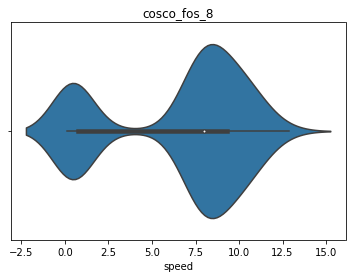

In [25]:
# use the seaborn violinplot function to visualize the distribution of the speed values
sns.violinplot(data=df, x='speed')
plt.title(f"cosco_fos_{voy_num}")

plt.show()

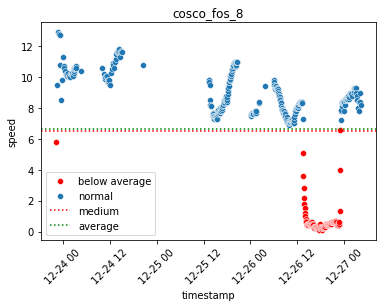

In [26]:
cosco_fos_26 = df
sns.scatterplot(
    data=cosco_fos_26[cosco_fos_26["speed"] < cosco_fos_26["speed"].mean()],
    x='timestamp',
    y='speed',
    color="red",
    label="below average")
sns.scatterplot(
    data=cosco_fos_26[cosco_fos_26["speed"] >= cosco_fos_26["speed"].mean()],
    x='timestamp',
    y='speed',
    label="normal")
plt.title(f"cosco_fos_{voy_num}")
plt.xticks(rotation=45)
# plt.axvline(x=cosco_fos_26["timestamp"].values[0],
#             color="pink",
#             linestyle="dashed",
#             label="dfdf")
# plt.axvline(x=cosco_fos_26["timestamp"].values[-1],
#             color="pink",
#             linestyle="dashed")
# plt.axhline(y=cosco_fos_23["speed"].mean(), linestyle="dotted")
plt.axhline(y=(cosco_fos_26["speed"].max() + cosco_fos_26["speed"].min()) / 2,
            linestyle="dotted",
            label="medium",
            color="red",
            )
plt.axhline(y=cosco_fos_26["speed"].mean(),
            linestyle="dotted",
            label="average",
            color="green",
            )
# use the seaborn violinplot function to visualize the distribution of the speed values
# sns.violinplot(data=cosco_fos_23, x='index', y='speed', inner="stick")
plt.legend()
plt.show()

# ETA 차이 확인

출발지점, 중간 지점, 도착 지점의 ETA 비교   
- proposed_ETA, AIS_ETA, TOS_ETA 비교군,
- ATA는 ATB 고려해서 계산. 2번에서 대기 시간 확인한 것 체크

AKA_BHUM_7
최대: 0 days 02:35:59.913062
평균: 0 days 00:52:21.511576473


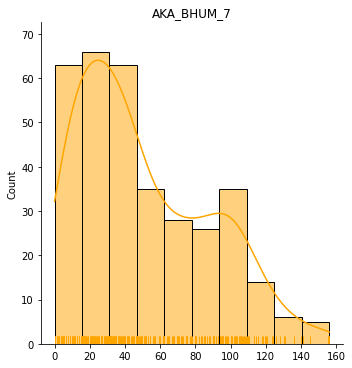

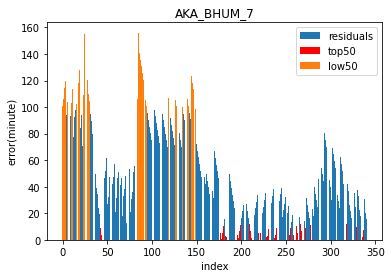

AKA_BHUM_8
최대: 0 days 11:37:49.205751
평균: 0 days 06:44:20.874588841


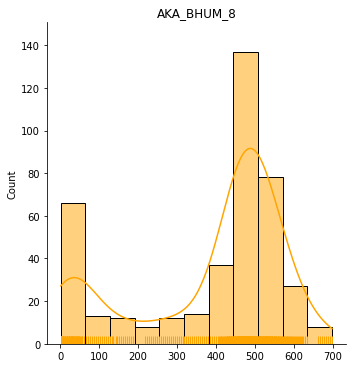

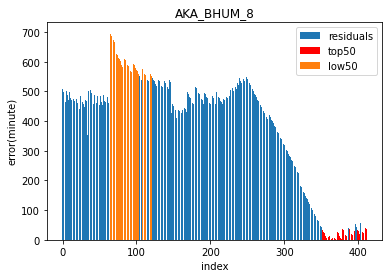

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

result_dfs = [aka_bhum_7, aka_bhum_8] # Replace with actual dataframes
voya_num = [7,8]
for i, df in enumerate(result_dfs):
    
    print(f"AKA_BHUM_{voya_num[i]}")
    print("최대:", df.loc[df.index[:-20]]["error"].max())
    print("평균:", df.loc[df.index[:-20]]["error"].mean())
    sns.displot(df["error"].values.astype(float) / (1e9 * 60), kde=True, rug=True, color="orange")
    plt.title(f"AKA_BHUM_{voya_num[i]}")
    plt.show()

    error_sorted = df.sort_values('error').dropna()
    high_threshold = error_sorted.iloc[50]["error"]
    low_threshold = error_sorted.iloc[-50]["error"]
    
    high_errors = df[df['error'] < high_threshold]
    low_errors = df[df['error'] > low_threshold]
    plt.bar(df["index"].values, df["error"].values.astype(float) /(1e9 * 60), label="residuals")
    plt.bar(high_errors["index"].values, high_errors["error"].values.astype(float) /(1e9 * 60), label="top50", color="red")
    plt.bar(low_errors["index"].values, low_errors["error"].values.astype(float) /(1e9 * 60), label="low50")
    
    plt.xlabel("index")
    plt.ylabel("error(minute)")
    plt.legend()
    plt.title(f"AKA_BHUM_{voya_num[i]}")
    plt.show()
    print("="*100)


## 7항차

In [28]:
AKBM003_df_eta_index = AKBM003_df["ETA"].drop_duplicates().index
AKBM003_df.loc[AKBM003_df_eta_index]

,TML_NUM,TML_CD,TML_CUD,VSL_CD,CALL_YEAR,CALL_SEQ,VOYAGE,PTNR_CODE,BERTH_NO,ALONG_SIDE,FROM_BITT,TO_BITT,ETA,ETB,ETW,ETC,ETD,ATA,ATB,ATW,ATC,ATD,YARD_OPEN,YARD_CLOSE,DIS_QTY,LOAD_QTY,UPDATE_TIME,timestamp
0,2216,PNIT,U,AKBM,2022,3,AKBM003,RCL,T2,P,23,41,2022-11-04 16:00:00,2022-11-04 17:00:00,NaN,NaN,2022-11-05 17:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-11 17:00:00,2022-11-04 07:00:00,600,500,2022-10-24 13:30:58,2022-10-24 13:35:28.074805
274,2216,PNIT,U,AKBM,2022,3,AKBM003,RCL,T2,P,23,41,2022-11-06 11:00:00,2022-11-06 12:00:00,NaN,NaN,2022-11-07 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-01 17:00:00,2022-11-06 02:00:00,600,500,2022-10-25 14:24:43,2022-10-25 14:29:29.075170
1908,2216,PNIT,U,AKBM,2022,3,AKBM003,RCL,T2,P,27.0,45,2022-11-05 11:00:00,2022-11-05 12:00:00,NaN,NaN,2022-11-06 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-02 12:00:00,2022-11-05 02:00:00,600,500,2022-10-26 15:11:50,2022-10-31 14:11:25.604957
1918,2216,PNIT,U,AKBM,2022,3,AKBM003,RCL,T2,P,24.0,42,2022-11-05 07:00:00,2022-11-05 08:00:00,NaN,NaN,2022-11-06 08:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-02 08:00:00,2022-11-04 22:00:00,600,500,2022-10-31 13:25:24,2022-10-31 14:56:51.325338
2212,2216,PNIT,U,AKBM,2022,3,AKBM003,RCL,T2,P,24.0,42,2022-11-05 18:00:00,2022-11-05 19:00:00,NaN,NaN,2022-11-06 19:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-01 17:00:00,2022-11-05 09:00:00,600,500,2022-11-01 15:55:35,2022-11-01 15:55:50.923291
2998,2216,PNIT,U,AKBM,2022,3,AKBM003,RCL,T2,P,22.0,40.0,2022-11-05 19:00:00,2022-11-05 20:00:00,NaN,NaN,2022-11-06 15:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-02 19:00:00,2022-11-05 09:00:00,567,359,2022-11-04 12:18:22,2022-11-04 12:23:29.520872


In [29]:
cf_port_mis_df[cf_port_mis_df["voyage_name"] == '9V7282_2022_7']['port_in_time']

2    2022-11-05 16:30:00
Name: port_in_time, dtype: object

In [30]:
AKBM003_df["ETA"].value_counts()

2022-11-06 11:00:00    1634
2022-11-05 18:00:00    1027
2022-11-04 16:00:00     566
2022-11-05 19:00:00      24
2022-11-05 11:00:00      10
2022-11-05 07:00:00       2
Name: ETA, dtype: int64

TOS_ETA
- 출항 전 : 2022-11-05 18:00:00
- 2022-11-04 12:23:29.520872 이후 : 2022-11-05 19:00:00
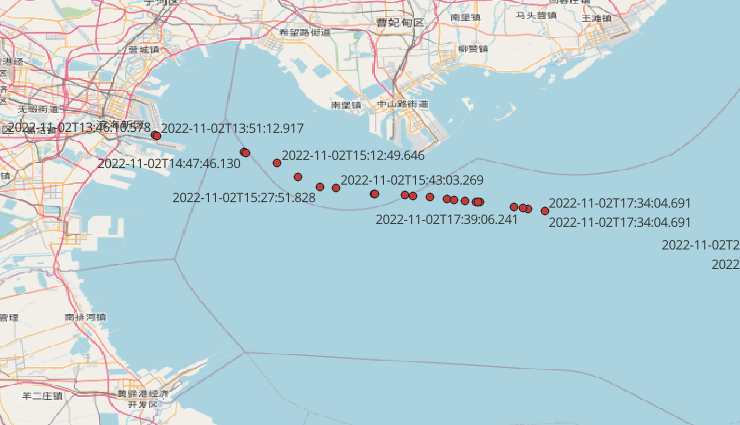
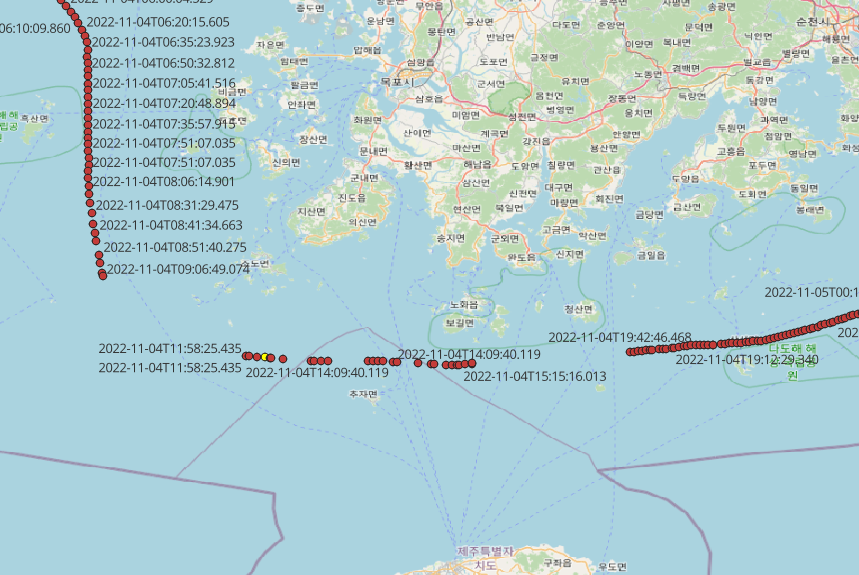

In [31]:
first_idx = aka_bhum_7[aka_bhum_7["timestamp"] < pd.to_datetime('2022-11-04 12:23:29.520872')].index
first_eta = '2022-11-05 18:00:00'

In [32]:
second_idx = aka_bhum_7[aka_bhum_7["timestamp"] >= pd.to_datetime('2022-11-04 12:23:29.520872')].index
second_eta = '2022-11-05 19:00:00'

In [33]:
aka_bhum_7.loc[first_idx,"TOS_ETA"] = first_eta
aka_bhum_7.loc[second_idx,"TOS_ETA"] = second_eta

- ATB : 2022-11-05 17:00:00

In [34]:
pnit_history = pd.read_excel("pnit_berth_history_2.xlsx")
pnit_history[pnit_history["모선항차"] == "AKBM003"]

,선석,선사,모선항차,선사항차,Head (Bridge) Stern,선명,ROUTE,반입마감시한,접안(예정)일시,출항(예정)일시,양하,적하,Shift,상태
228,T2(P),RCL,AKBM003,010W/010W,22 (34) 40,AKA BHUM,CIX3,2022-11-05 09:00:00,2022-11-05 17:00:00,2022-11-06 06:00:00,567,355,0,DEPARTED


In [35]:
aka_bhum_7["PNIT_ETB"] = '2022-11-05 17:00:00'

In [36]:
aka_bhum_7["PNIT_ETB"] = pd.to_datetime(aka_bhum_7["PNIT_ETB"])
aka_bhum_7["TOS_ETA"] = pd.to_datetime(aka_bhum_7["TOS_ETA"])
aka_bhum_7["waiting_time"] = abs(aka_bhum_7["PNIT_ETB"] - aka_bhum_7["ATA"] )
aka_bhum_7["ais_eta_error"] = abs(aka_bhum_7["ais_eta"] - aka_bhum_7["ATA"] )
aka_bhum_7["TOS_ETA_error"] = abs(aka_bhum_7["TOS_ETA"] - aka_bhum_7["ATA"] )

In [37]:
start_time = aka_bhum_7.loc[aka_bhum_7.index[0], "timestamp"]
end_time =aka_bhum_7.loc[aka_bhum_7.index[-1], "timestamp"]
middle_time = start_time + (end_time - start_time) / 2
aka_bhum_7['diff'] = abs(aka_bhum_7['timestamp'] - middle_time)
closest_index = aka_bhum_7['diff'].idxmin()

# Get the closest timestamp
closest_timestamp = aka_bhum_7.loc[closest_index, 'timestamp']

In [38]:
aka_bhum_7.drop(columns=["diff","eta",'mmsi','imo','CAPACITY'], inplace=True)

In [39]:
aka_bhum_7[aka_bhum_7["error"] > aka_bhum_7["ais_eta_error"]][["error","ais_eta_error"]]

,error,ais_eta_error
2,0 days 01:54:22.253084,0 days 01:36:09.691120
3,0 days 01:59:45.162240,0 days 01:36:09.691120
5,0 days 01:43:55.327936,0 days 01:36:09.691120
6,0 days 01:48:56.180447,0 days 01:36:09.691120
7,0 days 02:04:07.620612,0 days 01:36:09.691120
10,0 days 01:43:08.923508,0 days 01:36:09.691120
11,0 days 01:53:20.867652,0 days 01:36:09.691120
14,0 days 01:37:37.244046,0 days 01:36:09.691120
15,0 days 01:42:40.480572,0 days 01:36:09.691120
16,0 days 01:47:45.483114,0 days 01:36:09.691120


In [40]:
aka_bhum_7["ais_eta_error"].value_counts()

0 days 01:36:09.691120    339
1 days 04:36:09.691120      2
Name: ais_eta_error, dtype: int64

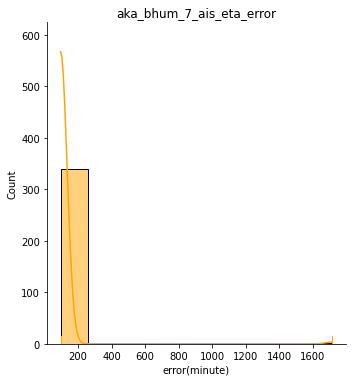

In [41]:
sns.displot(aka_bhum_7["ais_eta_error"].values.astype(float) / (1e9 * 60), kde=True, rug=True, color="orange")
plt.xlabel("error(minute)")
plt.title(f"aka_bhum_7_ais_eta_error")# sns.violinplot(data=cosco_fos_23, x='ais_eta_error_numeric')

plt.show()

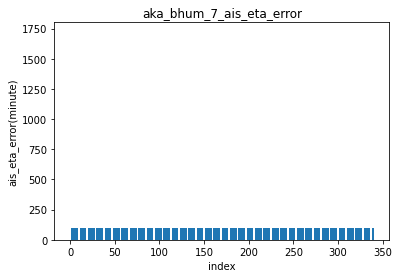

In [42]:
plt.bar(aka_bhum_7["index"].values, aka_bhum_7["ais_eta_error"].values.astype(float) /(1e9 * 60))
# sns.barplot(data=cosco_fos_23, x="index", y='ais_eta_error_numeric')

plt.xlabel("index")
plt.ylabel("ais_eta_error(minute)")
plt.yticks()
plt.title(f"aka_bhum_7_ais_eta_error")
plt.show()

In [43]:
aka_bhum_7["TOS_ETA_error"].value_counts()

0 days 08:23:50.308880    186
0 days 07:23:50.308880    155
Name: TOS_ETA_error, dtype: int64

In [44]:
cosco_fos_23 = aka_bhum_7

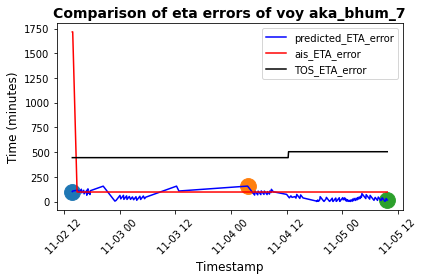

In [45]:
cosco_fos_23['error_minutes'] = cosco_fos_23['error'].dt.total_seconds() / 60
cosco_fos_23['ais_eta_error_minutes'] = cosco_fos_23['ais_eta_error'].dt.total_seconds() / 60
cosco_fos_23['TOS_ETA_error_minutes'] = cosco_fos_23['TOS_ETA_error'].dt.total_seconds() / 60

# plot the comparison using seaborn lineplot
sns.lineplot(data=cosco_fos_23, x="timestamp", y='error_minutes', color='blue', label="predicted_ETA_error")
sns.lineplot(data=cosco_fos_23, x="timestamp", y='ais_eta_error_minutes', color='red', label="ais_ETA_error")
sns.lineplot(data=cosco_fos_23, x="timestamp", y='TOS_ETA_error_minutes', color='black', label="TOS_ETA_error")

# plt.axvline(x=cosco_fos_23.timestamp[0],ymax=0.9,ymin=0.1,
#             linestyle="dotted",
#             label="medium",
#             color="red",
#             )

plt.scatter(x=cosco_fos_23.timestamp[0], y=cosco_fos_23.error_minutes[0], s=250)
# plt.scatter(x=cosco_fos_23.timestamp[0], y=cosco_fos_23.ais_eta_error_minutes[0])
# plt.scatter(x=cosco_fos_23.timestamp[0], y=cosco_fos_23.TOS_ETA_error_minutes[0])
plt.scatter(x=cosco_fos_23.timestamp[closest_index], y=cosco_fos_23.error_minutes[closest_index], s=250)
# plt.scatter(x=cosco_fos_23.timestamp[closest_index], y=cosco_fos_23.ais_eta_error_minutes[closest_index])
# plt.scatter(x=cosco_fos_23.timestamp[closest_index], y=cosco_fos_23.TOS_ETA_error_minutes[closest_index])
plt.scatter(x=cosco_fos_23.timestamp[cosco_fos_23.index[-1]], y=cosco_fos_23.error_minutes[cosco_fos_23.index[-1]], s=250)
# plt.scatter(x=cosco_fos_23.timestamp[cosco_fos_23.index[-1]], y=cosco_fos_23.ais_eta_error_minutes[cosco_fos_23.index[-1]])
# plt.scatter(x=cosco_fos_23.timestamp[cosco_fos_23.index[-1]], y=cosco_fos_23.TOS_ETA_error_minutes[cosco_fos_23.index[-1]])

# customize the plot to make it visually appealing
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Time (minutes)', fontsize=12)
plt.title('Comparison of eta errors of voy aka_bhum_7', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [46]:
cosco_fos_23.loc[[cosco_fos_23.index[0],closest_index,cosco_fos_23.index[-1]],['vessel_name','timestamp','ETA','ATA','waiting_time','error','ais_eta','TOS_ETA','PNIT_ETB','ais_eta_error','TOS_ETA_error']]

,vessel_name,timestamp,ETA,ATA,waiting_time,error,ais_eta,TOS_ETA,PNIT_ETB,ais_eta_error,TOS_ETA_error
0,AKA BHUM,2022-11-02 13:46:10.578457,2022-11-05 12:17:05.081740,2022-11-05 10:36:09.691120,0 days 06:23:50.308880,0 days 01:40:55.390620,2022-11-04 06:00:00,2022-11-05 18:00:00,2022-11-05 17:00:00,1 days 04:36:09.691120,0 days 07:23:50.308880
85,AKA BHUM,2022-11-04 03:33:41.281890,2022-11-05 08:00:09.778058,2022-11-05 10:36:09.691120,0 days 06:23:50.308880,0 days 02:35:59.913062,2022-11-05 09:00:00,2022-11-05 18:00:00,2022-11-05 17:00:00,0 days 01:36:09.691120,0 days 07:23:50.308880
340,AKA BHUM,2022-11-05 09:40:37.578352,2022-11-05 10:20:47.523648,2022-11-05 10:36:09.691120,0 days 06:23:50.308880,0 days 00:15:22.167472,2022-11-05 09:00:00,2022-11-05 19:00:00,2022-11-05 17:00:00,0 days 01:36:09.691120,0 days 08:23:50.308880


In [47]:
cosco_fos_23['waiting_time']

0     0 days 06:23:50.308880
1     0 days 06:23:50.308880
2     0 days 06:23:50.308880
3     0 days 06:23:50.308880
4     0 days 06:23:50.308880
               ...          
336   0 days 06:23:50.308880
337   0 days 06:23:50.308880
338   0 days 06:23:50.308880
339   0 days 06:23:50.308880
340   0 days 06:23:50.308880
Name: waiting_time, Length: 341, dtype: timedelta64[ns]

## 8항차

In [48]:
cf_port_mis_df[cf_port_mis_df["voyage_name"] == '9V7282_2022_8']['port_in_time']

3    2022-12-27 06:55:00
Name: port_in_time, dtype: object

In [49]:
AKBM004_df["ETA"].value_counts()

2022-12-23 16:00:00    6072
2022-12-24 16:00:00    2279
2022-12-27 09:00:00     721
2022-12-27 06:00:00     313
2022-12-26 19:00:00     246
2022-12-27 10:00:00     213
2022-12-26 17:00:00       7
Name: ETA, dtype: int64

In [50]:
AKBM004_df_eta_index = AKBM004_df["ETA"].drop_duplicates().index
AKBM004_df.loc[AKBM004_df_eta_index]

,TML_NUM,TML_CD,TML_CUD,VSL_CD,CALL_YEAR,CALL_SEQ,VOYAGE,PTNR_CODE,BERTH_NO,ALONG_SIDE,FROM_BITT,TO_BITT,ETA,ETB,ETW,ETC,ETD,ATA,ATB,ATW,ATC,ATD,YARD_OPEN,YARD_CLOSE,DIS_QTY,LOAD_QTY,UPDATE_TIME,timestamp
0,2440,PNIT,C,AKBM,2022,4,AKBM004,RCL,T2,P,NaN,NaN,2022-12-23 16:00:00,2022-12-23 17:00:00,NaN,NaN,2022-12-24 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-23 17:00:00,2022-12-23 07:00:00,600,500,NaN,2022-11-21 16:49:56.710003
6072,2440,PNIT,U,AKBM,2022,4,AKBM004,RCL,OT,P,53.0,NaN,2022-12-24 16:00:00,2022-12-24 17:00:00,NaN,NaN,2022-12-25 17:00:00,NaN,NaN,NaN,NaN,NaN,2022-12-19 17:00:00,2022-12-24 07:00:00,600,500,2022-12-14 17:11:55,2022-12-14 17:13:25.521382
8351,2440,PNIT,U,AKBM,2022,4,AKBM004,RCL,T1,P,1.0,19,2022-12-27 10:00:00,2022-12-27 10:00:00,NaN,NaN,2022-12-28 10:00:00,NaN,NaN,NaN,NaN,NaN,2022-12-20 17:00:00,2022-12-27 00:00:00,600,500,2022-12-19 13:59:06,2022-12-22 18:06:58.049129
8564,2440,PNIT,U,AKBM,2022,4,AKBM004,RCL,T1,P,1.0,19,2022-12-26 17:00:00,2022-12-26 18:00:00,NaN,NaN,2022-12-27 18:00:00,NaN,NaN,NaN,NaN,NaN,2022-12-23 14:00:00,2022-12-26 08:00:00,600,500,2022-12-23 11:51:52,2022-12-23 11:54:39.827664
8571,2440,PNIT,U,AKBM,2022,4,AKBM004,RCL,T1,P,1.0,19,2022-12-26 19:00:00,2022-12-26 20:00:00,NaN,NaN,2022-12-27 18:00:00,NaN,NaN,NaN,NaN,NaN,2022-12-22 18:00:00,2022-12-26 08:00:00,600,500,2022-12-23 12:25:36,2022-12-23 12:29:46.369633
8817,2440,PNIT,U,AKBM,2022,4,AKBM004,RCL,T1,P,1.0,19.0,2022-12-27 09:00:00,2022-12-27 10:00:00,NaN,NaN,2022-12-28 08:00:00,NaN,NaN,NaN,NaN,NaN,2022-12-22 18:00:00,2022-12-26 08:00:00,600,500,2022-12-24 09:17:11,2022-12-24 09:17:57.143643
9538,2440,PNIT,U,AKBM,2022,4,AKBM004,RCL,T1,P,1.0,19,2022-12-27 06:00:00,2022-12-27 07:00:00,NaN,NaN,2022-12-28 03:00:00,NaN,NaN,NaN,NaN,NaN,2022-12-23 10:00:00,2022-12-26 08:00:00,970,345,2022-12-26 21:52:13,2022-12-26 21:55:26.258709


TOS_ETA
- 출항 전 : 2022-12-26 19:00:00
- 2022-12-24 09:17:57.143643 이후 : 2022-12-27 09:00:00
- 2022-12-26 21:55:26.258709 이후 : 2022-12-27 06:00:00
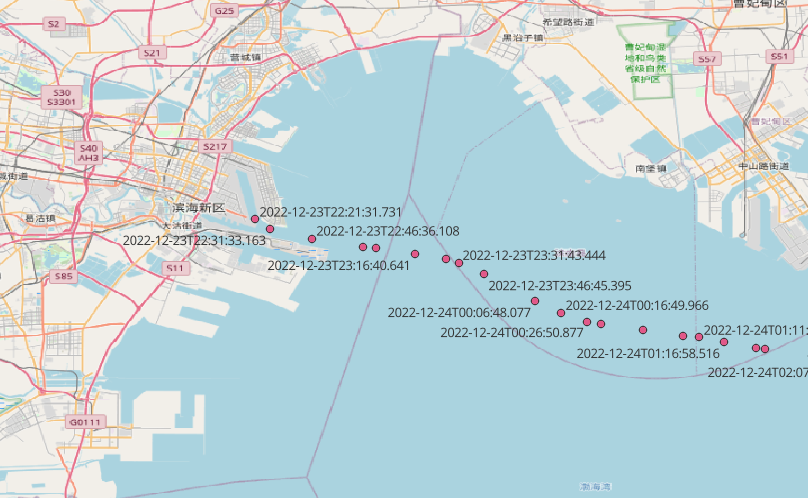
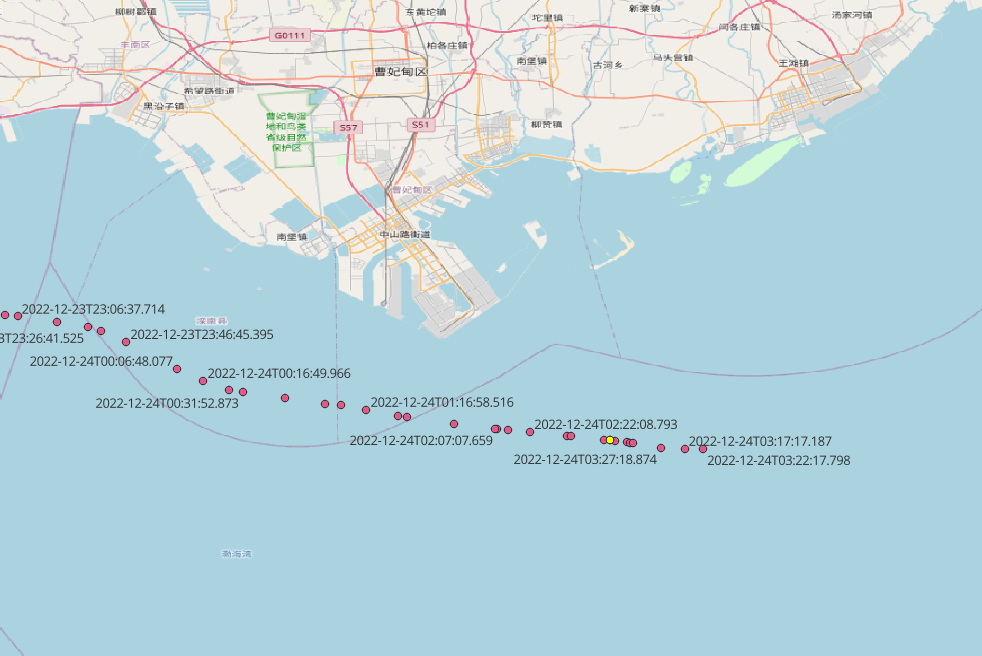
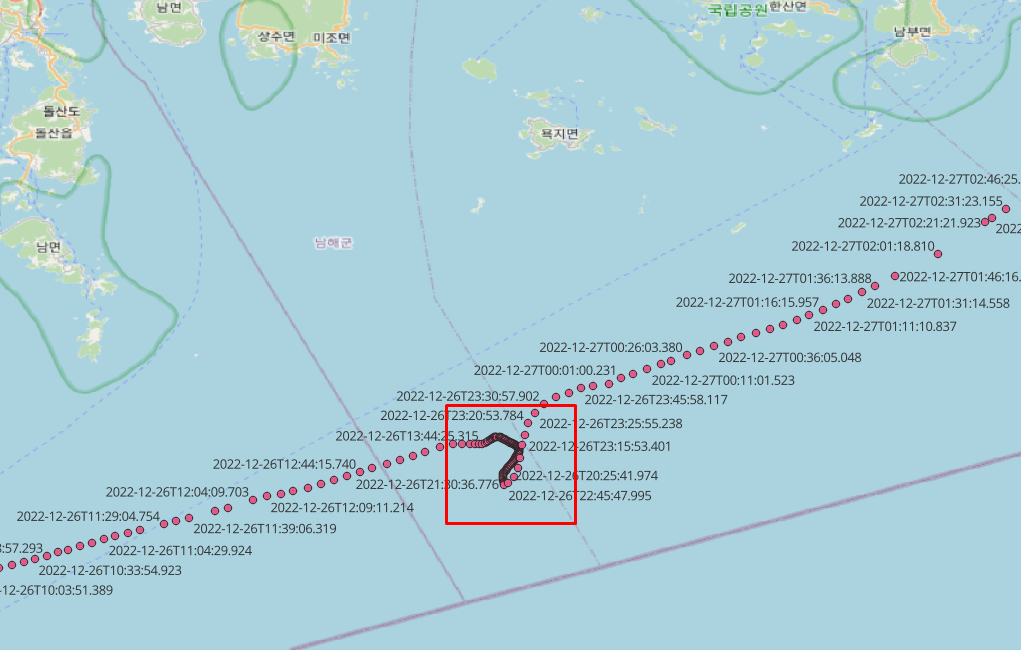

In [51]:
first_idx = aka_bhum_8[aka_bhum_8["timestamp"] < pd.to_datetime('2022-12-24 09:17:57.143643')].index
first_eta = '2022-12-26 19:00:00'

In [52]:
second_idx = aka_bhum_8[
    (aka_bhum_8["timestamp"] > pd.to_datetime('2022-12-24 09:17:57.143643'))
    & (aka_bhum_8["timestamp"] <= pd.to_datetime(
        '2022-12-26 21:55:26.258709'))].index
second_eta = '2022-12-27 09:00:00'

In [53]:
third_idx = aka_bhum_8[aka_bhum_8["timestamp"] >= pd.to_datetime('2022-12-26 21:55:26.258709')].index
third_eta = '2022-12-27 06:00:00'

In [54]:
aka_bhum_8.loc[first_idx,"TOS_ETA"] = first_eta
aka_bhum_8.loc[second_idx,"TOS_ETA"] = second_eta
aka_bhum_8.loc[third_idx,"TOS_ETA"] = third_eta

- ATB : 2022-12-27 07:15:00

In [55]:
pnit_history = pd.read_excel("pnit_berth_history_2.xlsx")
pnit_history[pnit_history["모선항차"] == "AKBM004"]

,선석,선사,모선항차,선사항차,Head (Bridge) Stern,선명,ROUTE,반입마감시한,접안(예정)일시,출항(예정)일시,양하,적하,Shift,상태
339,T1(P),RCL,AKBM004,010E/011W,01 (13) 19,AKA BHUM,CIX3,2022-12-26 08:00:00,2022-12-27 07:15:00,2022-12-28,970,342,0,DEPARTED


In [56]:
aka_bhum_8["PNIT_ETB"] = '2022-12-27 07:15:00'

In [57]:
aka_bhum_8["PNIT_ETB"] = pd.to_datetime(aka_bhum_8["PNIT_ETB"])
aka_bhum_8["TOS_ETA"] = pd.to_datetime(aka_bhum_8["TOS_ETA"])
aka_bhum_8["waiting_time"] = abs(aka_bhum_8["PNIT_ETB"] - aka_bhum_8["ATA"] )
aka_bhum_8["ais_eta_error"] = abs(aka_bhum_8["ais_eta"] - aka_bhum_8["ATA"] )
aka_bhum_8["TOS_ETA_error"] = abs(aka_bhum_8["TOS_ETA"] - aka_bhum_8["ATA"] )

In [58]:
start_time = aka_bhum_8.loc[aka_bhum_8.index[0], "timestamp"]
end_time =aka_bhum_8.loc[aka_bhum_8.index[-1], "timestamp"]
middle_time = start_time + (end_time - start_time) / 2
aka_bhum_8['diff'] = abs(aka_bhum_8['timestamp'] - middle_time)
closest_index = aka_bhum_8['diff'].idxmin()

# Get the closest timestamp
closest_timestamp = aka_bhum_8.loc[closest_index, 'timestamp']

In [59]:
aka_bhum_8.drop(columns=["diff","eta",'mmsi','imo','CAPACITY'], inplace=True)

In [60]:
aka_bhum_8[aka_bhum_8["error"] > aka_bhum_8["ais_eta_error"]][["error","ais_eta_error"]]

,error,ais_eta_error
208,0 days 08:17:52.420705,0 days 06:39:11.654525
209,0 days 08:12:50.297627,0 days 06:39:11.654525
210,0 days 08:07:50.451426,0 days 06:39:11.654525
211,0 days 08:02:49.263919,0 days 06:39:11.654525
212,0 days 07:57:48.889031,0 days 06:39:11.654525
...,...,...
280,0 days 06:59:14.536552,0 days 06:39:11.654525
281,0 days 06:54:14.149265,0 days 06:39:11.654525
282,0 days 06:49:13.198599,0 days 06:39:11.654525
283,0 days 06:44:12.675941,0 days 06:39:11.654525


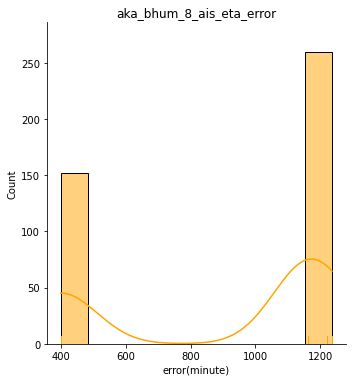

In [61]:
sns.displot(aka_bhum_8["ais_eta_error"].values.astype(float) / (1e9 * 60), kde=True, rug=True, color="orange")
plt.xlabel("error(minute)")
plt.title(f"aka_bhum_8_ais_eta_error")# sns.violinplot(data=cosco_fos_23, x='ais_eta_error_numeric')

plt.show()

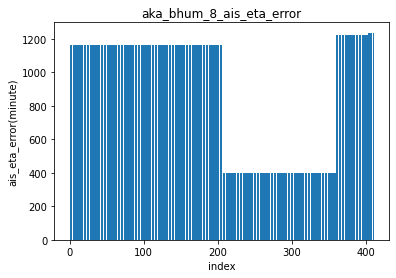

In [62]:
plt.bar(aka_bhum_8["index"].values, aka_bhum_8["ais_eta_error"].values.astype(float) /(1e9 * 60))
# sns.barplot(data=cosco_fos_23, x="index", y='ais_eta_error_numeric')

plt.xlabel("index")
plt.ylabel("ais_eta_error(minute)")
plt.yticks()
plt.title(f"aka_bhum_8_ais_eta_error")
plt.show()

In [63]:
aka_bhum_8["TOS_ETA_error"].value_counts()

0 days 03:38:11.654525    314
0 days 00:38:11.654525     63
0 days 10:21:48.345475     35
Name: TOS_ETA_error, dtype: int64

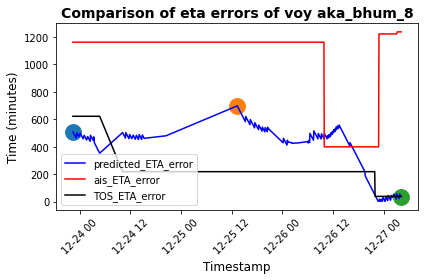

In [64]:
cosco_fos_23 = aka_bhum_8
cosco_fos_23['error_minutes'] = cosco_fos_23['error'].dt.total_seconds() / 60
cosco_fos_23['ais_eta_error_minutes'] = cosco_fos_23['ais_eta_error'].dt.total_seconds() / 60
cosco_fos_23['TOS_ETA_error_minutes'] = cosco_fos_23['TOS_ETA_error'].dt.total_seconds() / 60

# plot the comparison using seaborn lineplot
sns.lineplot(data=cosco_fos_23, x="timestamp", y='error_minutes', color='blue', label="predicted_ETA_error")
sns.lineplot(data=cosco_fos_23, x="timestamp", y='ais_eta_error_minutes', color='red', label="ais_ETA_error")
sns.lineplot(data=cosco_fos_23, x="timestamp", y='TOS_ETA_error_minutes', color='black', label="TOS_ETA_error")

# plt.axvline(x=cosco_fos_23.timestamp[0],ymax=0.9,ymin=0.1,
#             linestyle="dotted",
#             label="medium",
#             color="red",
#             )

plt.scatter(x=cosco_fos_23.timestamp[0], y=cosco_fos_23.error_minutes[0], s=250)
# plt.scatter(x=cosco_fos_23.timestamp[0], y=cosco_fos_23.ais_eta_error_minutes[0])
# plt.scatter(x=cosco_fos_23.timestamp[0], y=cosco_fos_23.TOS_ETA_error_minutes[0])
plt.scatter(x=cosco_fos_23.timestamp[closest_index], y=cosco_fos_23.error_minutes[closest_index], s=250)
# plt.scatter(x=cosco_fos_23.timestamp[closest_index], y=cosco_fos_23.ais_eta_error_minutes[closest_index])
# plt.scatter(x=cosco_fos_23.timestamp[closest_index], y=cosco_fos_23.TOS_ETA_error_minutes[closest_index])
plt.scatter(x=cosco_fos_23.timestamp[cosco_fos_23.index[-1]], y=cosco_fos_23.error_minutes[cosco_fos_23.index[-1]], s=250)
# plt.scatter(x=cosco_fos_23.timestamp[cosco_fos_23.index[-1]], y=cosco_fos_23.ais_eta_error_minutes[cosco_fos_23.index[-1]])
# plt.scatter(x=cosco_fos_23.timestamp[cosco_fos_23.index[-1]], y=cosco_fos_23.TOS_ETA_error_minutes[cosco_fos_23.index[-1]])

# customize the plot to make it visually appealing
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Time (minutes)', fontsize=12)
plt.title('Comparison of eta errors of voy aka_bhum_8', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [65]:
aka_bhum_8.loc[[aka_bhum_8.index[0],closest_index,aka_bhum_8.index[-1]],['vessel_name','timestamp','ETA','ATA','waiting_time','error','ais_eta','TOS_ETA','PNIT_ETB','ais_eta_error','TOS_ETA_error']]

,vessel_name,timestamp,ETA,ATA,waiting_time,error,ais_eta,TOS_ETA,PNIT_ETB,ais_eta_error,TOS_ETA_error
0,AKA BHUM,2022-12-23 22:21:31.730568,2022-12-26 20:52:26.233851,2022-12-27 05:21:48.345475,0 days 01:53:11.654525,0 days 08:29:22.111624,2022-12-26 10:00:00,2022-12-26 19:00:00,2022-12-27 07:15:00,0 days 19:21:48.345475,0 days 10:21:48.345475
64,AKA BHUM,2022-12-25 13:17:30.643556,2022-12-26 17:43:59.139724,2022-12-27 05:21:48.345475,0 days 01:53:11.654525,0 days 11:37:49.205751,2022-12-26 10:00:00,2022-12-27 09:00:00,2022-12-27 07:15:00,0 days 19:21:48.345475,0 days 03:38:11.654525
411,AKA BHUM,2022-12-27 04:06:36.128527,2022-12-27 04:46:46.073823,2022-12-27 05:21:48.345475,0 days 01:53:11.654525,0 days 00:35:02.271652,2022-12-26 08:45:00,2022-12-27 06:00:00,2022-12-27 07:15:00,0 days 20:36:48.345475,0 days 00:38:11.654525


In [66]:
aka_bhum_8['waiting_time']

0     0 days 01:53:11.654525
1     0 days 01:53:11.654525
2     0 days 01:53:11.654525
3     0 days 01:53:11.654525
4     0 days 01:53:11.654525
               ...          
407   0 days 01:53:11.654525
408   0 days 01:53:11.654525
409   0 days 01:53:11.654525
410   0 days 01:53:11.654525
411   0 days 01:53:11.654525
Name: waiting_time, Length: 412, dtype: timedelta64[ns]

# waiting time

In [71]:
voyage_list = [7, 8, "avg"]
waiting_list = [
    '0 days 06:23:50.308880','0 days 01:53:11.654525'
]
waiting_list = pd.to_timedelta(waiting_list)

In [72]:
waiting_list = waiting_list.values.astype(float) / (1e9 * 60)

In [73]:
waiting_list = np.append(waiting_list, np.mean(waiting_list))

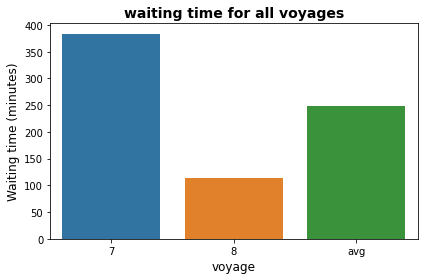

In [74]:
sns.barplot(x=voyage_list, y=waiting_list)
plt.xlabel('voyage', fontsize=12)
plt.ylabel('Waiting time (minutes)', fontsize=12)
plt.title('waiting time for all voyages', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()